In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import seaborn as sns

from yaml import safe_load


sns.set_theme(style="white", rc={"grid.color": "lightgray"})
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))

In [3]:
params = safe_load(open("../experiments.yml", "r"))
reward_ranges = {
    value["gym_id"].replace("mo-", ""): {
        "r_max": value["r_max"],
        "r_min": value["r_min"],
    }
    for value in params["Dylam"].values()
}

In [4]:
def smooth_curve(points: np.array, factor: int = 100):
    cumsum = np.cumsum(np.insert(points, 0, 0))
    return (cumsum[factor:] - cumsum[:-factor]) / float(factor)

In [5]:
lambdas = {
    x.replace(".csv", ""): pd.read_csv(f"LunarLander/{x}.csv")
    for x in ["Shaping", "Power_Linear", "Power_Angular", "Landing_Rate"]
}

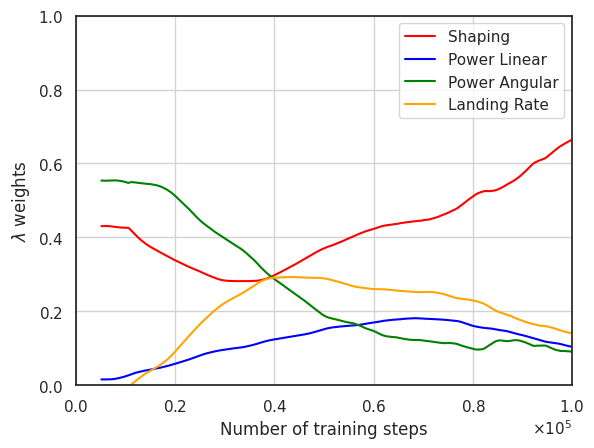

In [5]:
fig, ax = plt.subplots()
lines = []
COLOR = {
    0: "red",
    1: "blue",
    2: "green",
    3: "orange",
}

for i, weight in enumerate(lambdas.keys()):
    (line,) = ax.plot([], [], label=weight.replace("_", " "), color=COLOR[i])
    lines.append(line)

ax.set_xlim(0, max(lambdas[weight]["Step"]))
ax.set_ylim(0, 1)
ax.set_xlabel("Number of training steps")
ax.set_ylabel(r"$\lambda$ weights")
ax.grid(True)
ax.legend()
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)


def init():
    for line in lines:
        line.set_data([], [])
    return lines


def animate(frame):
    for i, weight in enumerate(lambdas.keys()):
        mean_key = [
            key
            for key in lambdas[weight].keys()
            if not (
                key.startswith("Step") or key.endswith("MAX") or key.endswith("MIN")
            )
        ][0]
        x = lambdas[weight]["Step"][:frame]
        y = smooth_curve(lambdas[weight][mean_key], factor=1)[:frame]
        lines[i].set_data(x, y)
    return lines


ani = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=len(lambdas[weight]["Step"]),
    interval=5,
    blit=True,
)
ani.save(filename="lambdas.mp4", writer="ffmpeg")

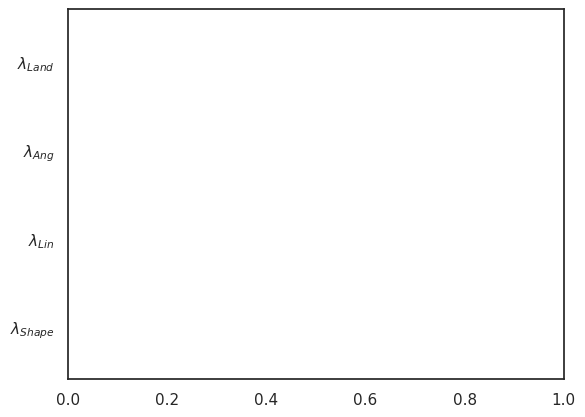

In [22]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
curves = []
for i, weight in enumerate(lambdas.keys()):
    mean_key = [
        key
        for key in lambdas[weight].keys()
        if not (key.startswith("Step") or key.endswith("MAX") or key.endswith("MIN"))
    ][0]

    curves.append(smooth_curve(lambdas[weight][mean_key], factor=1))
curves = np.array(curves)
x = [r"$\lambda_{Shape}$", r"$\lambda_{Lin}$", r"$\lambda_{Ang}$", r"$\lambda_{Land}$"]

artists = []
colors = ["tab:red", "tab:blue", "tab:green", "tab:orange"]
for i in range(curves.shape[1]):
    container = ax.barh(x, curves[:, i], color=colors)
    artists.append(container)

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=5)
ani.save(filename="lambdas_bal.mp4", writer="ffmpeg")

In [5]:
rewards = {
    x.replace("rew-", ""): pd.read_csv(f"LunarLander/{x}.csv")
    for x in [
        "rew-Shaping",
        "rew-Power_Linear",
        "rew-Power_Angular",
        "rew-Landing_Rate",
    ]
}
reward_max = reward_ranges["LunarLander-v2"]["r_max"]
reward_min = reward_ranges["LunarLander-v2"]["r_min"]

In [10]:
fig, ax = plt.subplots()
lines = []

PARAM = {
    0: ("red", (0, (3, 1))),
    1: ("blue", (0, (3, 4))),
    2: ("green", (0, (3, 8))),
    3: ("orange", (0, (3, 12))),
}


def normalize_rewards(rew, reward_max, reward_min):
    rew = np.array(rew)
    abs_max = max(abs(reward_max), abs(reward_min))
    rew = rew / abs_max
    return rew


normalized_max_rewards = [
    normalize_rewards([reward_max[i]], reward_max[i], reward_min[i])
    for i in range(len(reward_max))
]
for i, reward in enumerate(rewards.keys()):
    (line,) = ax.plot([], [], label=reward.replace("_", " "), color=PARAM[i][0])
    lines.append(line)
    x = rewards[reward]["Step"].loc[99:]
    r_max_line = [normalized_max_rewards[i]] * len(x)
    ax.plot(x, r_max_line, color=PARAM[i][0], linestyle=PARAM[i][1])

ax.set_xlim(0, max(rewards[reward]["Step"]) + 10)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel("Number of training steps")
ax.set_ylabel("Cumulative Episode Rewards (Normalized)")
ax.grid(True)
ax.legend(loc="lower right")
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)


def init():
    for line in lines:
        line.set_data([], [])
    return lines


def animate(frame):
    for i, reward in enumerate(rewards.keys()):
        mean_key = [
            key
            for key in rewards[reward].keys()
            if not (
                key.startswith("Step") or key.endswith("MAX") or key.endswith("MIN")
            )
        ][0]
        x = rewards[reward]["Step"][:frame]
        y = smooth_curve(rewards[reward][mean_key], factor=100)[:frame]
        y = normalize_rewards(y, reward_max[i], reward_min[i])
        lines[i].set_data(x, y)
    return lines


ani = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=[i for i in range(0, len(rewards[reward]["Step"]), 8)],
    interval=5,
    blit=True,
)
ani.save(filename="rewards.mp4", writer="ffmpeg")

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (7320,) and arg 1 with shape (7319,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (7320,) and arg 1 with shape (7319,).

<Figure size 640x480 with 1 Axes>